# MS4610 Introduction to Data Analytics || Course Project
Compilation notebook by **Group 12**

In this project, we were asked to develop a model which can predict whether a person applying for a credit card will default in paying the card bills in the next 12 months. The dataset provided contained around 48 predictors with information about previous interactions of the customer with the bank and that taken from the customer bureau. In the sections that follow, we present our approaches towards cleaning the dataset, exploratory data analysis and model selection and tuning.

For ease of reference, we renamed the columns of the data so that they are easier to refer to. The new column names are below.

1. **train.csv**
    - `application_key`: primary key for dataset
    - `credit_score`: credit worthiness based on past transactions
    - `risk_score`: score based on number and riskiness of enquiries
    - `sev_def_any`: severity of default on any loan
    - `sev_def_auto`: severity of default on auto loans
    - `sev_def_edu`: severity of default on education loans
    - `min_credit_rev`: minimum credit on all revolving cards
    - `max_credit_act`: maximum credit on all active credit lines
    - `max_credit_act_rev`: maximum credit on all active revolving cards
    - `total_credit_1_miss`: sum of credit on all cards where borrower missed 1 payment
    - `total_credit`: total credit on all accepted credit lines
    - `due_collected`: amount of dues collected post default where due was more than 500
    - `total_due`: sum of amount due on all active credit cards
    - `annual_pay`: annual amount paid towards all cards last year
    - `annual_income`: annual income of individual
    - `property_value`: estimated market value of property owned by customer
    - `fc_cards_act_rev`: no. of active revolving credit cards on which full credit utilized
    - `fc_cards_act`: no. of active credit cards on which full credit utilized
    - `fc_lines_act`: no. of active credit lines on which full credit utilized
    - `pc_cards_act`: no. of active credit cards on which at least 75% credit utilized
    - `pc_lines_act`: no. of active credit lines on which at least 75% credit utilized
    - `loan_util_act_rev`: average utilization (%) on active revolving credit card loans
    - `line_util_past2`: average utilization (%) of line on all credit lines activated in past 2 years
    - `line_util_past1`: average utilization (%) of line on all credit cards activated in past 1 year
    - `line_util_1_miss`: Average utilization of line on credit cards on which the borrower has missed 1 payment during last 6 months (%)
    - `tenure_act_rev`: average tenure of active revolving credit cards
    - `tenure_oldest_act`: tenure of oldest card among all active cards
    - `tenure_oldest_act_rev`: tenure of oldest revolving card among all active revolving cards
    - `last_miss_time`: number days since last miss of payment on any credit lines
    - `tenure_oldest_line`: tenure of oldest line
    - `max_tenure_auto`: maximum tenure on all auto loans
    - `max_tenure_edu`: maximum tenure on all education loans
    - `total_tenure_act`: sum of tenures (months) on all active credit cards
    - `residence_time`: duration of stay at current residential address
    - `lines_act_1_miss`: number of active credit lines in past 6 months with 1 payment missed
    - `cards_rev_1_miss`: numer of revolving credit cards in last 2 year with 1 payment missed
    - `lines_act`: number of active credit lines
    - `cards_act_t2`: credit cards with tenure of at least 2 years
    - `lines_act_2yrs`: number of credit lines activated in last 2 years
    - `lines_deli`: number of lines on which borrower has current delinquency
    - `line_util_edu`: utilization of lines (%) on active education loans
    - `line_util_auto`: utilization of lines (%) on active auto loans
    - `stress_index`: financial stress index of borrower
    - `lines_high_risk`: Number of credit lines on which the borrower has never missed a payment in last 2 yrs, yet considered as high risk loans based on market prediction of economic scenario
    - `max_due_ratio`: ratio of maximum amount due on all credit lines to sum of amounts due on all credit lines
    - `mort_2_miss`: number of mortgage loans on which 2 payments are missed
    - `auto_2_miss`: number of auto loans on which 2 payments are missed
    - `card_type`: C = Charge card or L = Lending card, which the customer applied for
    - `location_id`: location ID
    - `default_ind`: Default indicator

# Data Cleaning and Augmentation

In this section, we prepare the data so it can be used by our models. Basically, we will replace various tags given to missing values with the `np.nan` missing value placeholder. After this, we will label encode the `card_type` column to convert it into a **numeric** column. Then we will convert some columns into **integer** and **float** types.

In [92]:
# Data handling libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
%matplotlib inline

# Classifiers

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# Other libraries

import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import our dataset

train = pd.read_csv(".././data/train.csv")
test = pd.read_csv(".././data/test.csv")

### Analysis of missing values

In this subsection, we analyze the quantity and distribution of missing values in the dataset. This will help us find ways to impute them, if necessary. However, as we will later see, it is necessary to keep missing values as it is because a value being missing itself is an important piece of information.

In [3]:
# First we replace the various tags for missing values with np.nan

miss_tags = ['missing', 'na', 'N/A']

for col in train.columns:
    for i in range(len(train)):
        if train.at[i, col] in miss_tags:
            train.at[i, col] = np.nan

In [4]:
# For the test dataset

miss_tags = ['missing', 'na', 'N/A']

for col in test.columns:
    for i in range(len(test)):
        if test.at[i, col] in miss_tags:
            test.at[i, col] = np.nan

In [5]:
# Function to summarize missing values in a dataset

def missing_table(df, threshold=None, ascending=False):
    """
    Counts number of missing values and percentage of missing values in every column
    of input pandas DataFrame object.
    
    :params: 
        threshold: (int/float) returns only those columns with number/percentage of missing
                   values higher than this value, default is None (returns all columns)
        ascending: (boolean) sorts table in ascending order of missing values
                   if set to True, default is False
                   
    :return: columns with missing values above threshold; pandas DataFrame object with column 
             name, number of missing values and percentage of missing values
    """
    cols = df.columns
    miss_vals = np.array([df[col].isnull().sum() for col in cols])
    miss_vals_percent = (miss_vals.astype('float') / len(df))*100
    
    miss_table = pd.DataFrame(np.vstack((cols, miss_vals, miss_vals_percent)).T,
                              columns=['column', 'missing values', '% missing values'])
    
    if threshold is None:
        miss_table = miss_table.sort_values(by='missing values', ascending=ascending)
        return miss_table
    else:
        if threshold <= 1.0:
            ret = miss_table.loc[miss_table['% missing values'] >= threshold*100.0, :]
            return ret.sort_values(by='missing values', ascending=ascending)
        elif threshold > 1.0:
            ret = miss_table.loc[miss_table['missing values'] >= threshold, :]
            return ret.sort_values(by='missing values', ascending=ascending)
        else:
            raise ValueError('Invalid threshold type')

In [6]:
# For training dataset
missing_table(train, threshold=0.0, ascending=False)

,column,missing values,% missing values
40,line_util_edu,65070,78.3976
31,max_tenure_edu,58539,70.5289
41,line_util_auto,57264,68.9928
11,due_collected,46717,56.2855
45,mort_2_miss,45920,55.3253
23,line_util_past1,42311,50.9771
30,max_tenure_auto,37988,45.7687
35,cards_rev_1_miss,34868,42.0096
15,property_value,33519,40.3843
22,line_util_past2,30668,36.9494


In [7]:
# For test dataset
missing_table(test, threshold=0.0, ascending=False)

,column,missing values,% missing values
40,line_util_edu,36901,78.5128
31,max_tenure_edu,33143,70.517
41,line_util_auto,32258,68.634
11,due_collected,26518,56.4213
45,mort_2_miss,26034,55.3915
23,line_util_past1,23977,51.0149
30,max_tenure_auto,21475,45.6915
35,cards_rev_1_miss,19765,42.0532
15,property_value,18836,40.0766
22,line_util_past2,17368,36.9532


The distribution of missing values seems similar in both training and test datasets. Thus similar imputation strategies can be used on both.

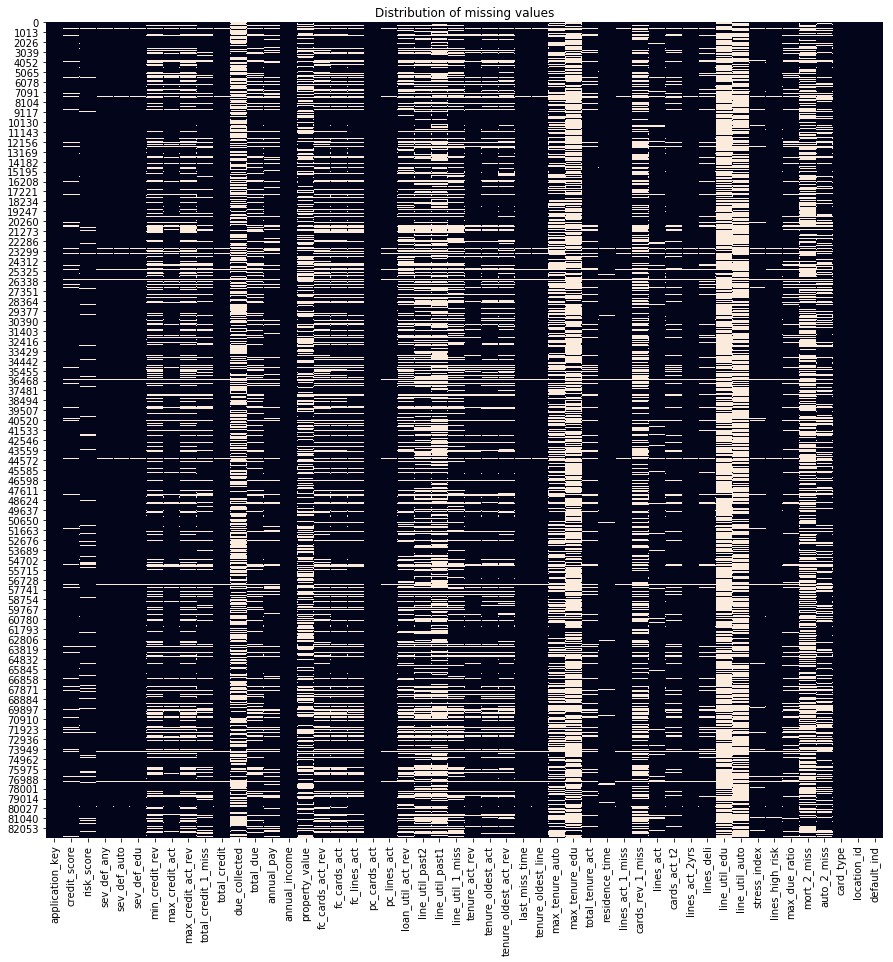

In [8]:
# Here, we check the distribution of missing values.
# In the plot below, the white lines represent missing values while black areas have non-null values.

plt.figure(figsize=(15,15))
sns.heatmap(train.isnull(), cbar=False)
plt.title('Distribution of missing values')
plt.show()

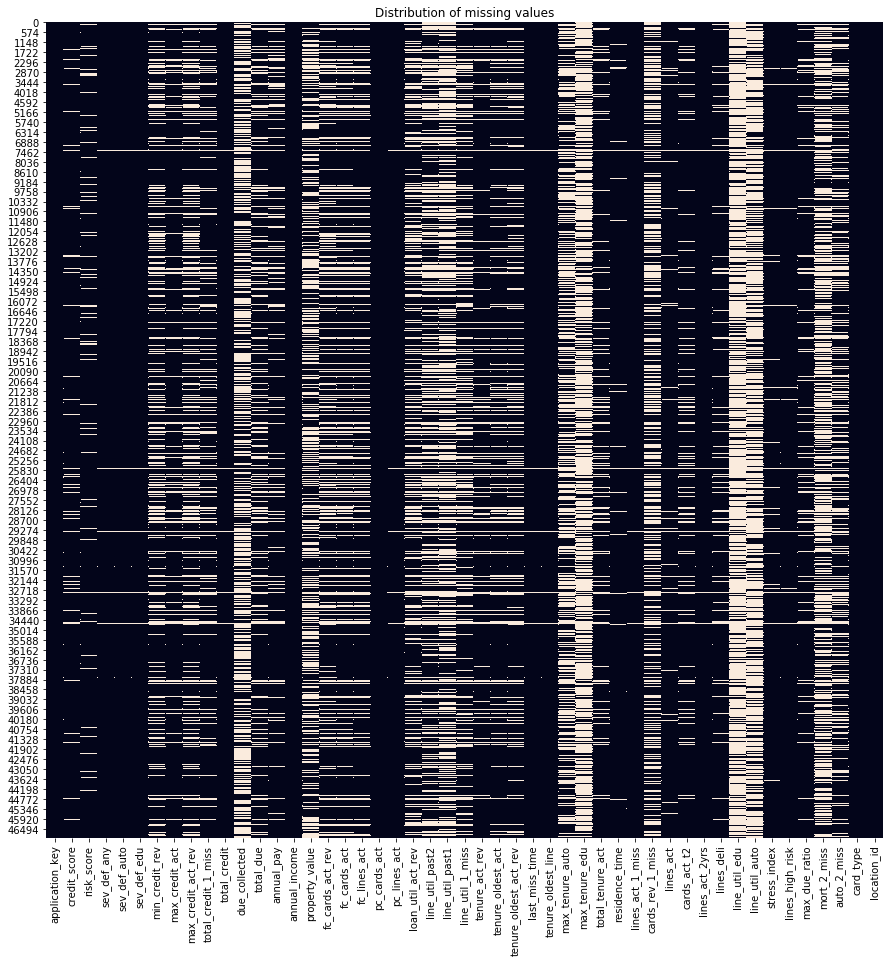

In [9]:
# For the test dataset
plt.figure(figsize=(15,15))
sns.heatmap(test.isnull(), cbar=False)
plt.title('Distribution of missing values')
plt.show()

**Some observations**
1. Few rows have almost all columns with missing values; dropping these rows will make some columns free from missing values
2. Some columns seem to be taking missing values in the same records (symmetrically). Is it possible that these columns are correlated? For instance, the heatmap of these columns look almost identical:
    1. `min_credit_rev` and `max_credit_act_rev`
    2. `total_tenure_act` and `cards_act_t2`
    3. `fc_cards_act`, `fc_lines_act` and `fc_cards_act_rev`
    4. `max_due_ratio` and `lines_deli`

### Label Encoding non-numeric columns

The `card_type` column is not of a numeric type and cannot be processed by our models directly. We will label encode it into zeros and ones.

In [10]:
enc_columns = ['card_type']

le = LabelEncoder()
train[enc_columns] = le.fit_transform(train[enc_columns])
test[enc_columns] = le.transform(test[enc_columns])

In [11]:
# Converting all columns to float type

for df in [train, test]:
    for col in df.columns:
        df[col] = df[col].astype('float')

That is all the preprocessing we did. We haven't imputed missing values, because the models gave best performance on unimputed datasets. We tried various imputation techniques which we haven't shown here. Also, we tried resampling to reduce class imbalance using SMOTE. To see this part of our work, please check out [this](https://github.com/NishantPrabhu/MS4610-Project-2019/blob/master/code/DataCleaning.ipynb) notebook in our GitHub repo.

# Exploratory Data Analysis (EDA)

In this section, we look at various aspects of the data statistically and graphically. This will help us in explaining our model's behavior to some extent. Also, we would like to check out the distribution of values in various predictors for normality and skewness, which is sometimes detrimental to model performance.

In [13]:
# Stastical analysis libraries

from scipy.stats import probplot, chisquare
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from lightgbm import LGBMClassifier
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

In [14]:
# Checking for class imbalance
# How well is each class represented in the train data

train['default_ind'] = train.default_ind.astype('int')
values_table = train.default_ind.value_counts()

# Imablance correction hyperarameter for XGBoost and LightGBM
scale_pos_weight = values_table.values.astype('float')[0]/values_table.values.astype('float')[1]

print(values_table)
print('')
print("scale_pos_weight: {:.4f}".format(scale_pos_weight))

0    59145
1    23855
Name: default_ind, dtype: int64

scale_pos_weight: 2.4794


### Useful Functions

Here we have defined some functions which are used in EDA very often. We then directly use it in the cells that follow.

In [22]:
def dist_dashboard(df, target, num_cols, transform=None):
    """
    Displays distribution and prob-plots for numeric columns in the input dataset side-by-side
    
    :param num_cols: (list-like) List of columns with numeric data (non-object)
    
    :return:
        Displays series of plots with histogram of column data and prob-plot side-by-side
    """
    for col in num_cols:
        col_vals = df.loc[df[col].notnull(), [col, target]]
        pos_vals = col_vals.loc[col_vals[target] == 0, col].values
        neg_vals = col_vals.loc[col_vals[target] == 1, col].values
        plt.figure(figsize=(15,5))

        # Plot histogram of values
        plt.subplot(131)
        sns.distplot(pos_vals, kde=True, hist=False)
        sns.distplot(neg_vals, kde=True, hist=False)
        plt.grid()
        plt.title(col)
        plt.xticks(rotation=90)
        plt.ylabel('frequency')

        # Plot probplot for normal distribution
        plt.subplot(132)
        probplot(train.loc[train[col].notnull(), col].values, dist='norm', plot=plt)
        plt.grid()
        plt.title(col)
        
        # Plot probplot for transformed distribution
        plt.subplot(133)
        probplot(train.loc[train[col].notnull(), col].apply(transform).values, dist='norm', plot=plt)
        plt.grid()
        plt.title(col + ": " + str(transform))

        plt.tight_layout()
        plt.show()

### Distribution and ProbPlots

Here, we check out the distribution of numeric columns and generate probplots to check their conformance with normal distribution. In addition, we also apply log transform to reduce skewness and check their probplot again (far right). We will analyze only the training data here.

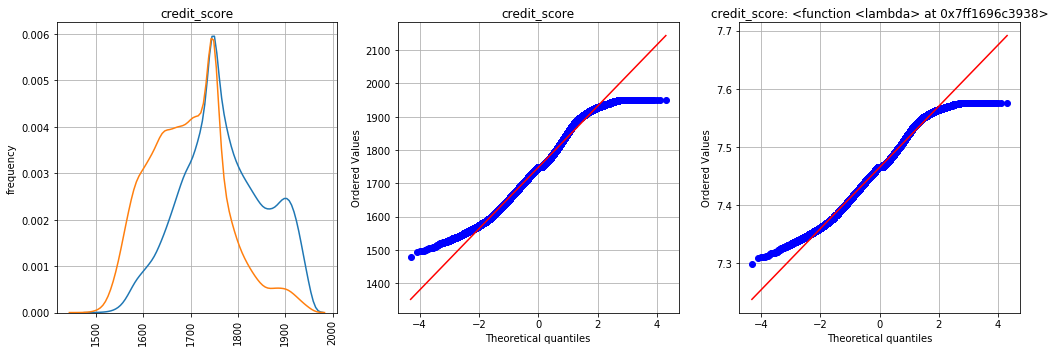

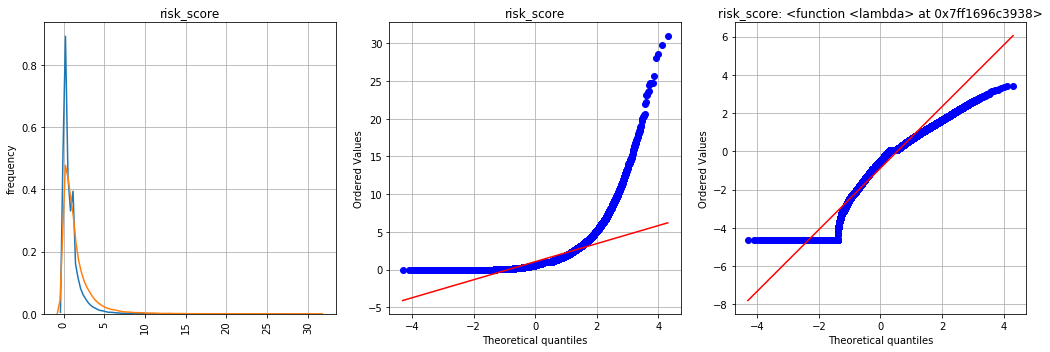

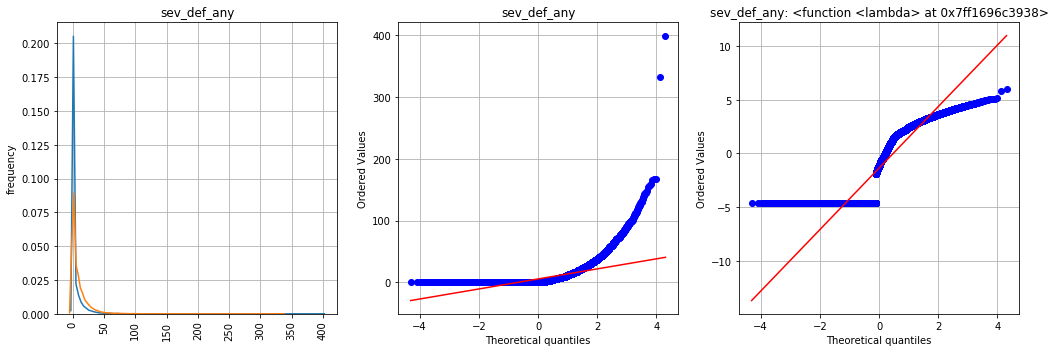

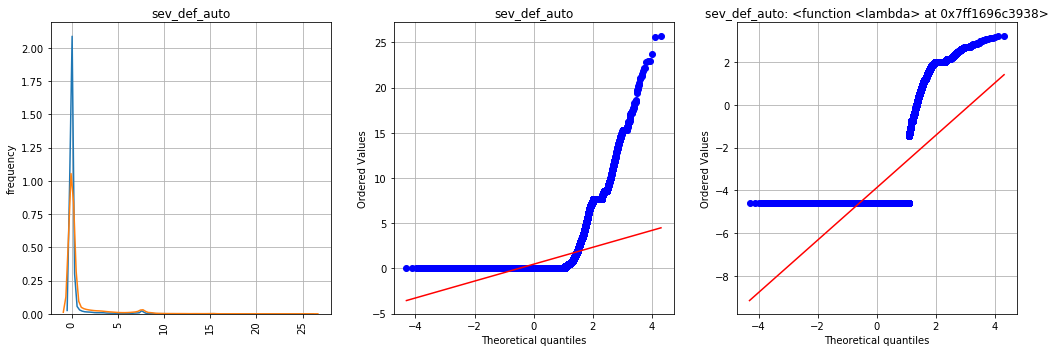

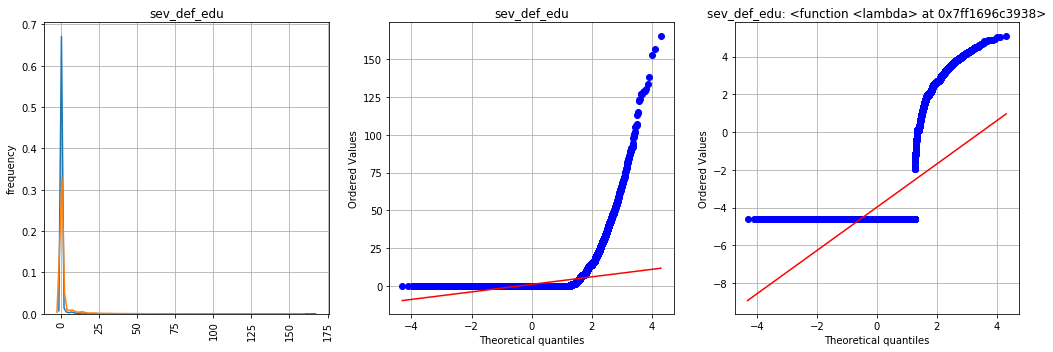

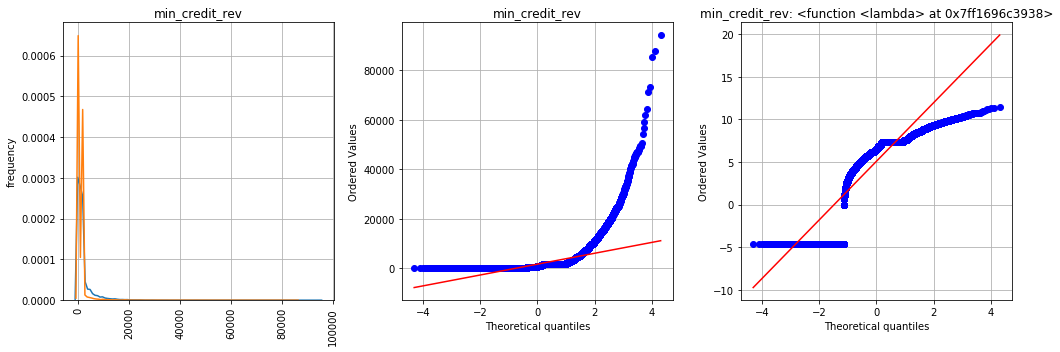

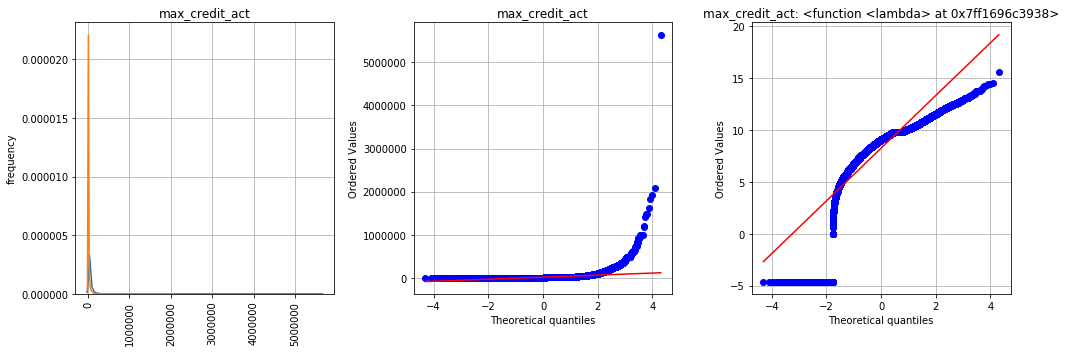

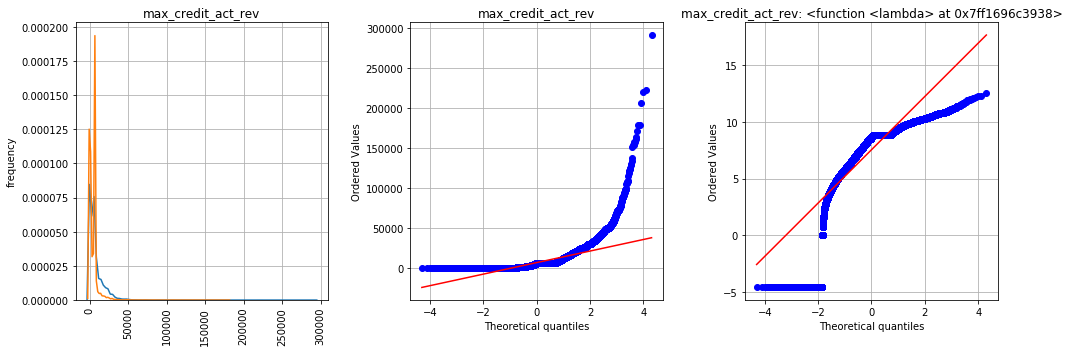

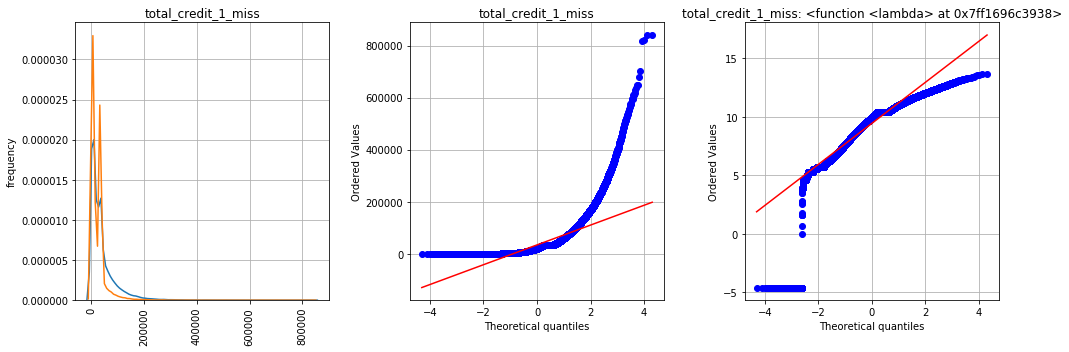

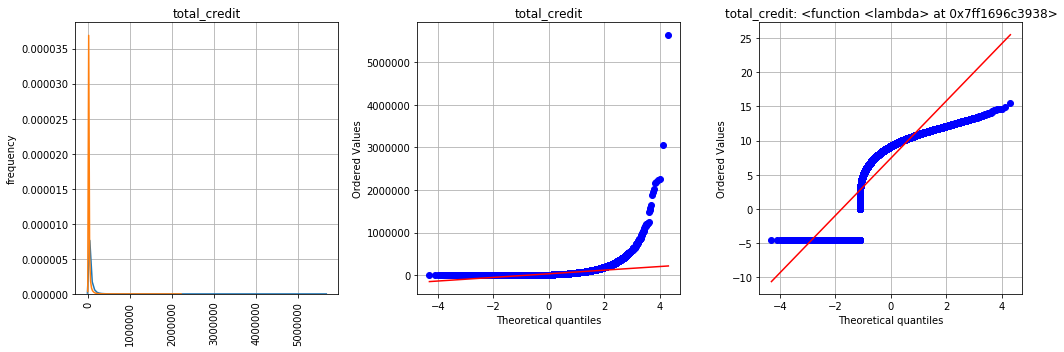

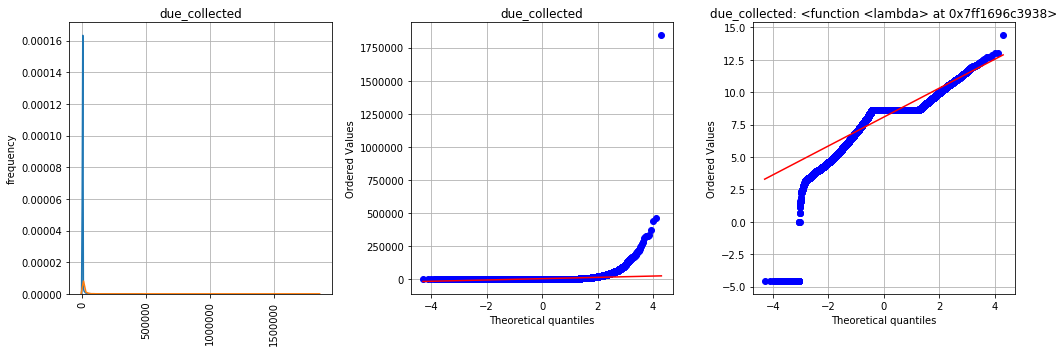

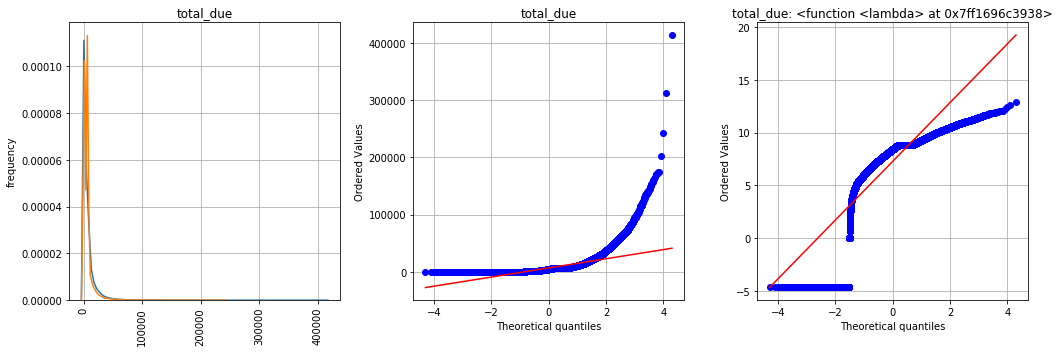

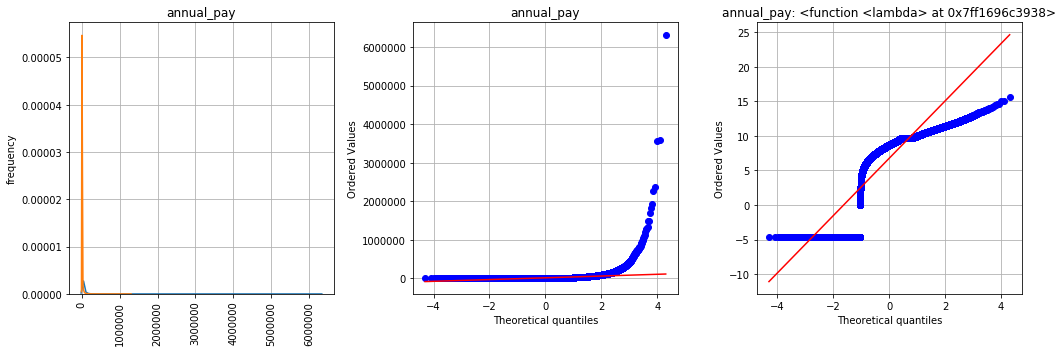

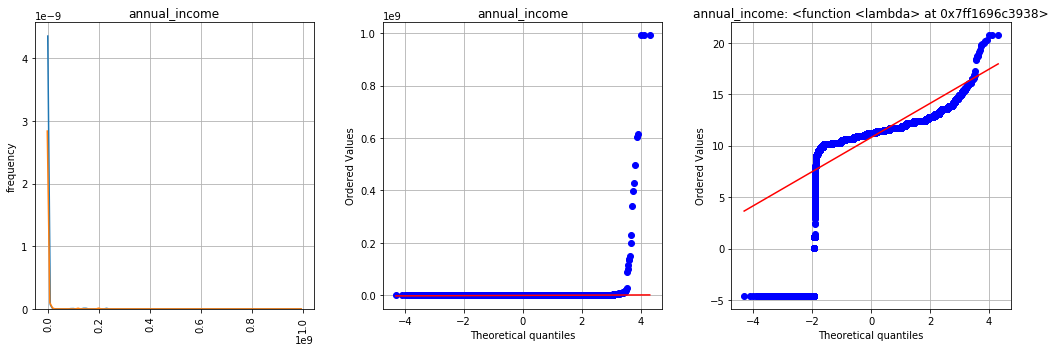

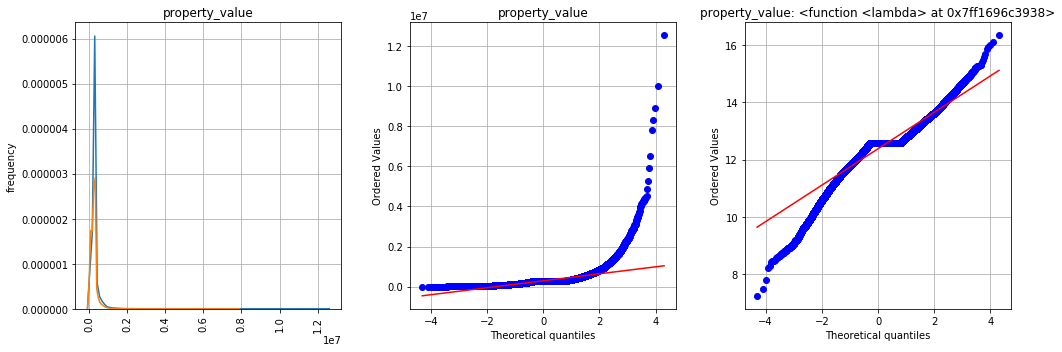

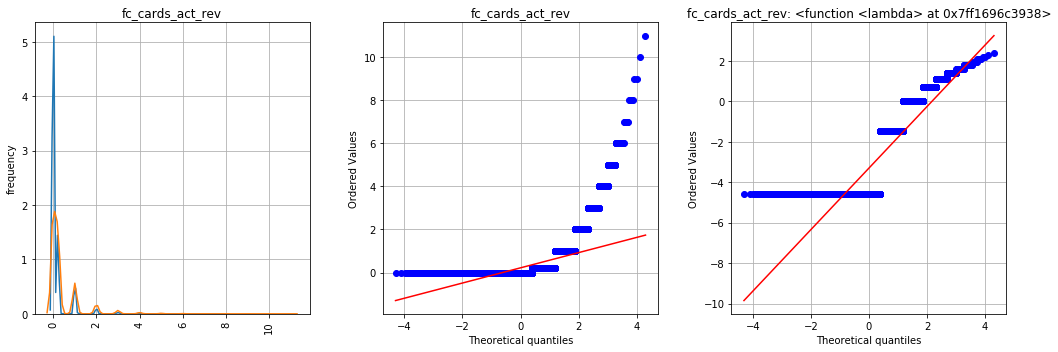

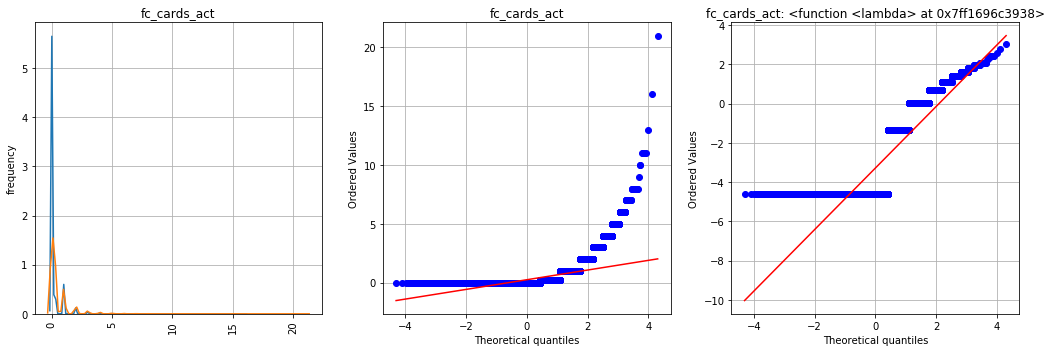

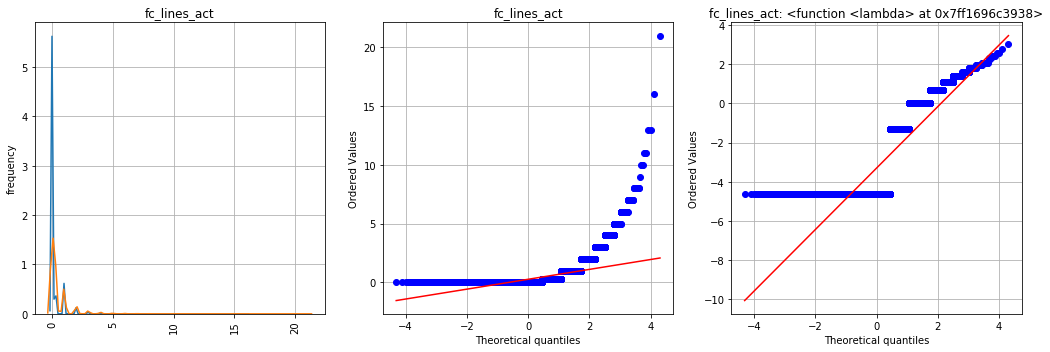

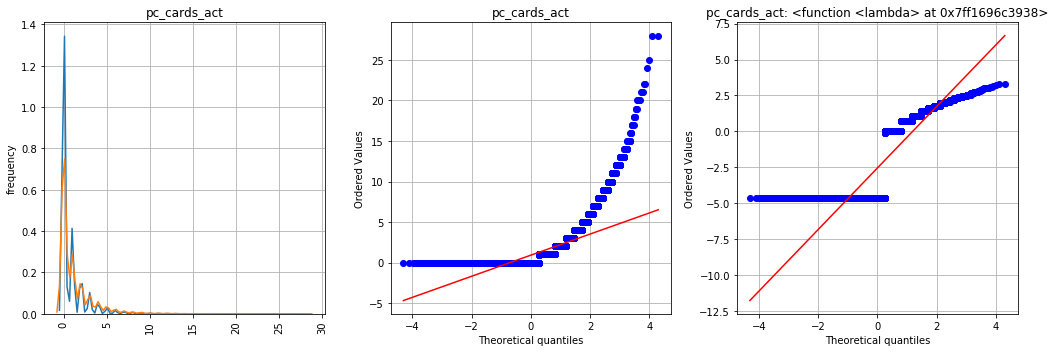

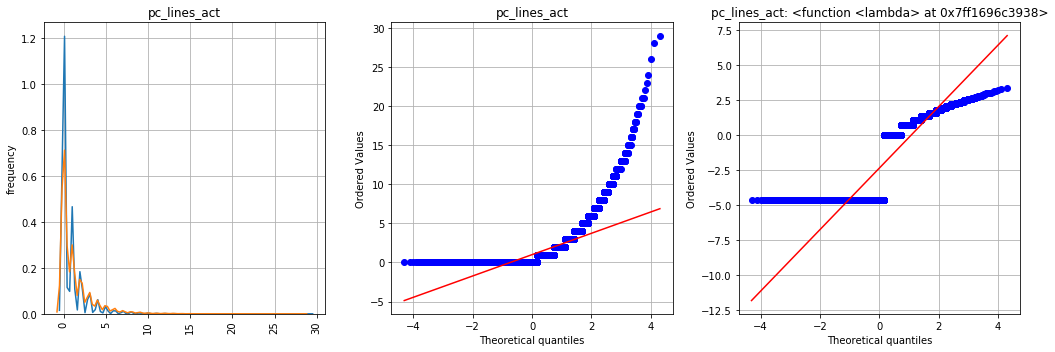

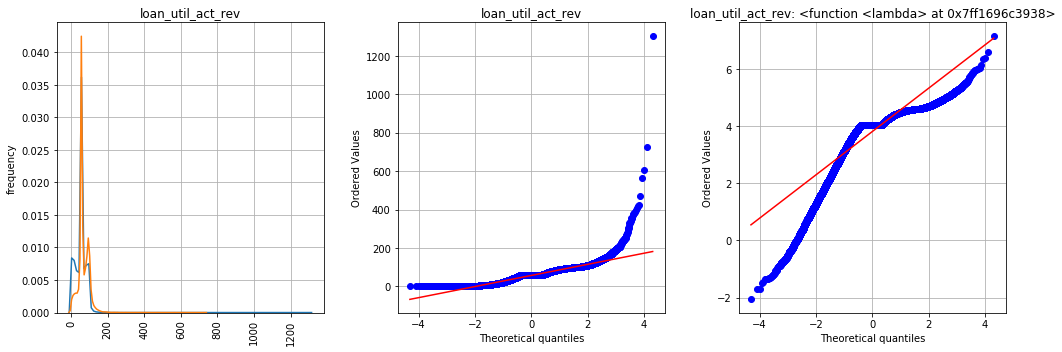

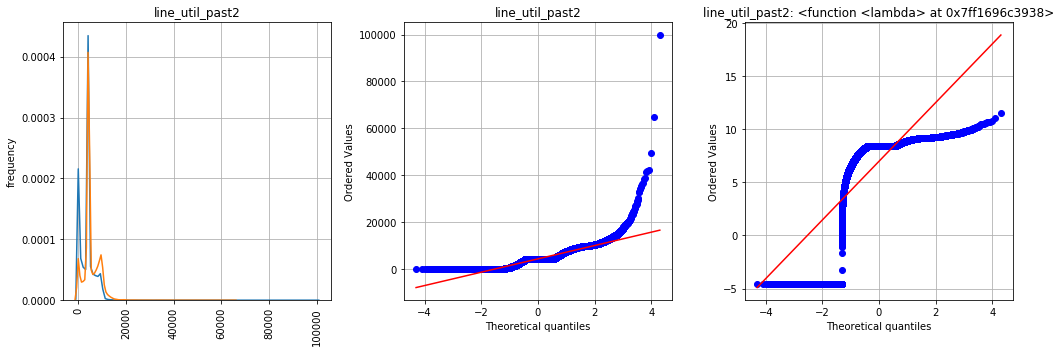

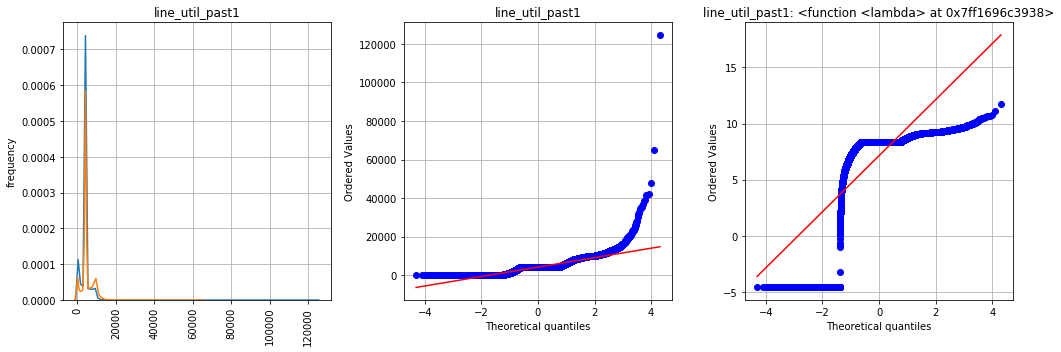

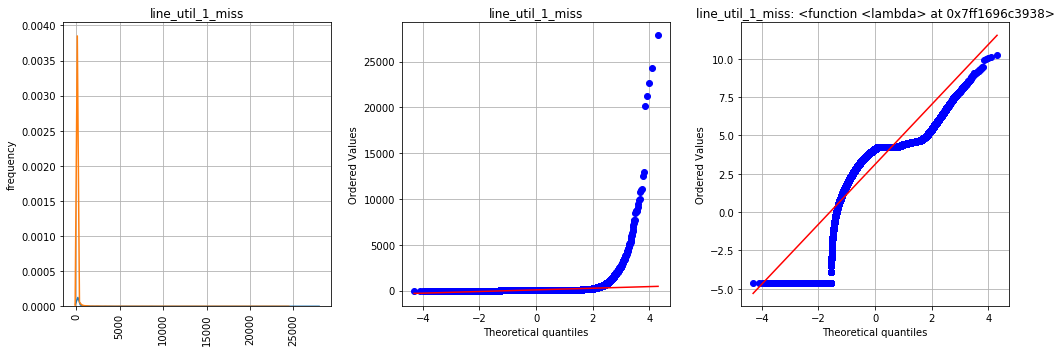

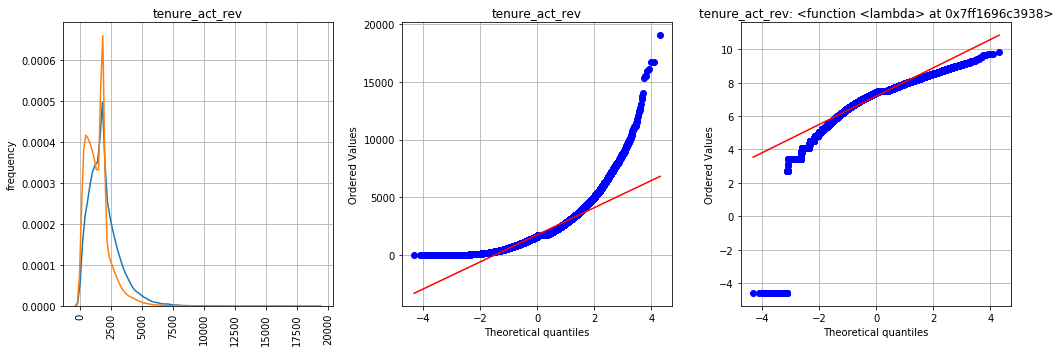

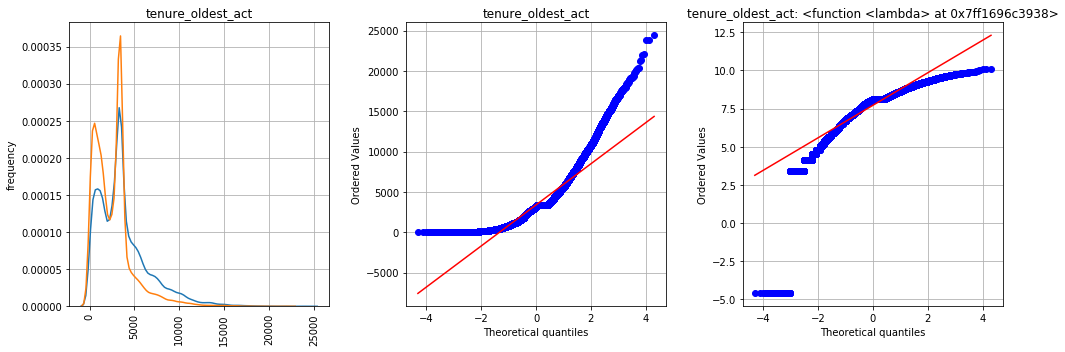

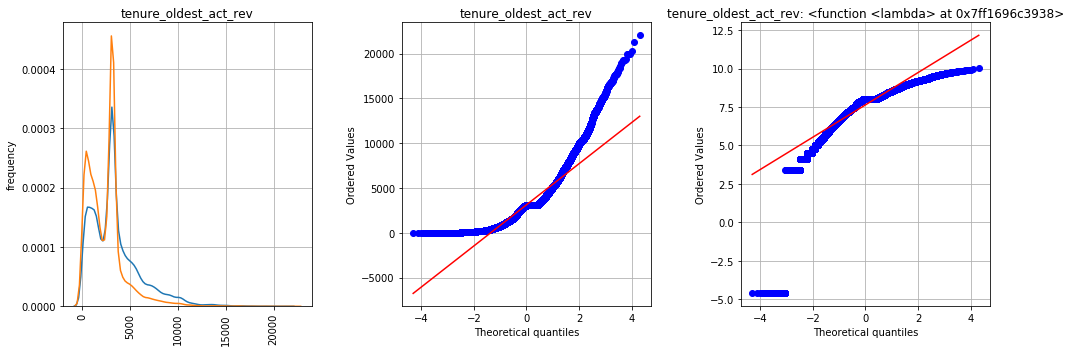

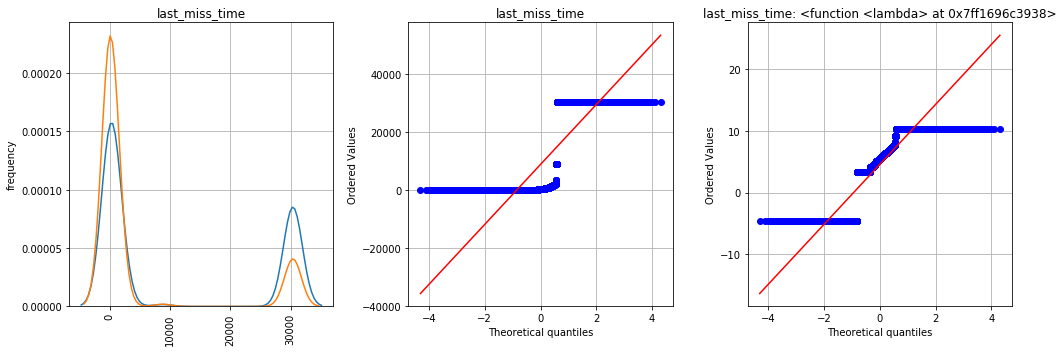

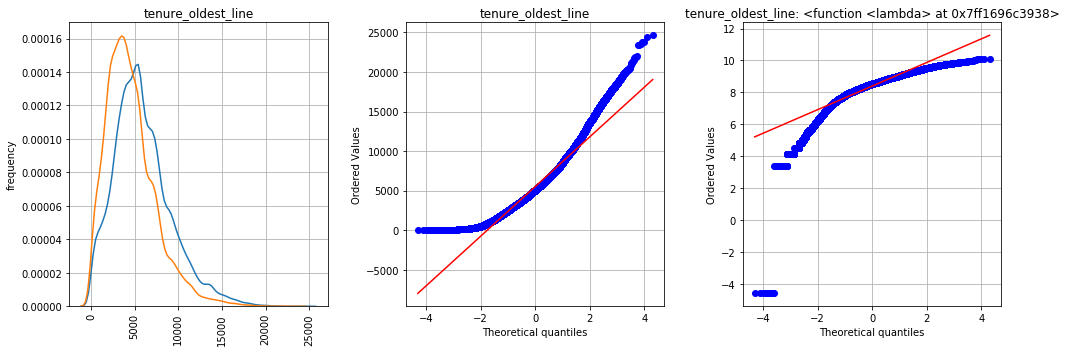

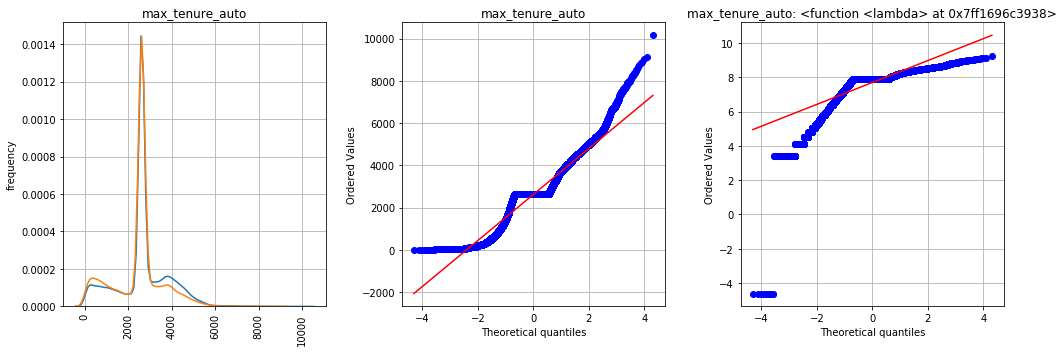

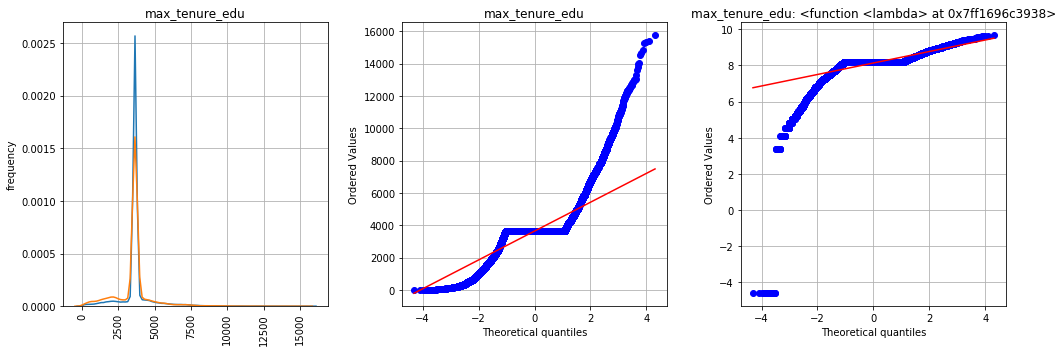

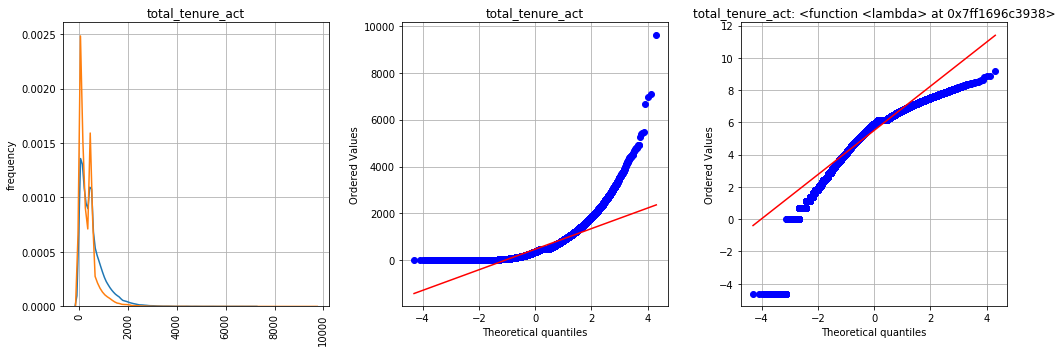

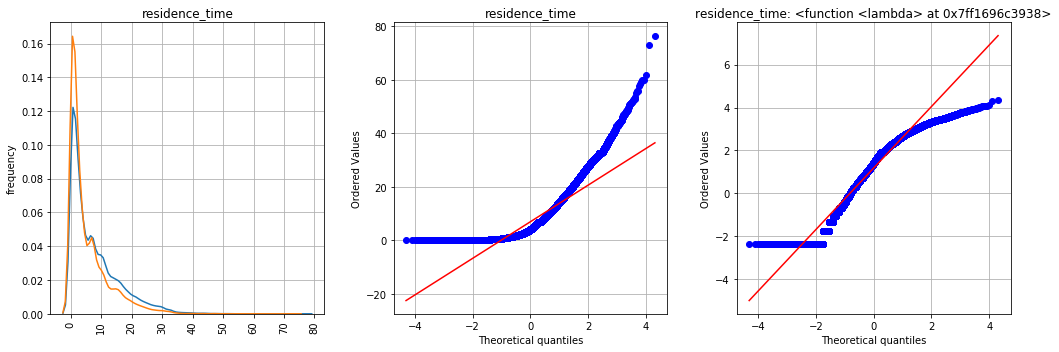

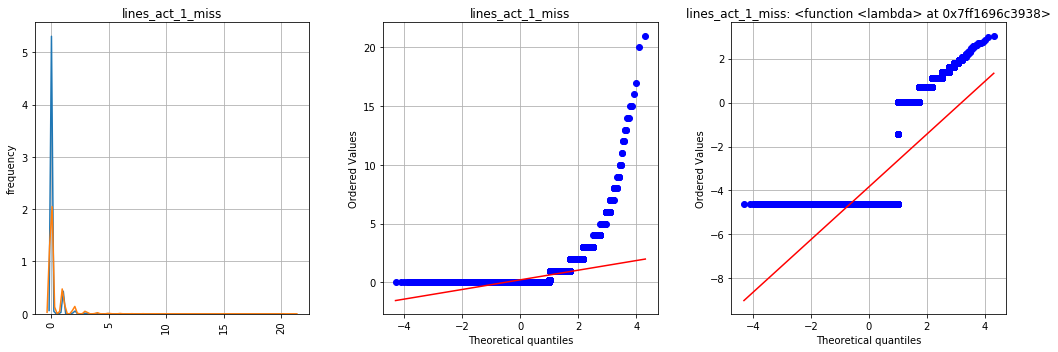

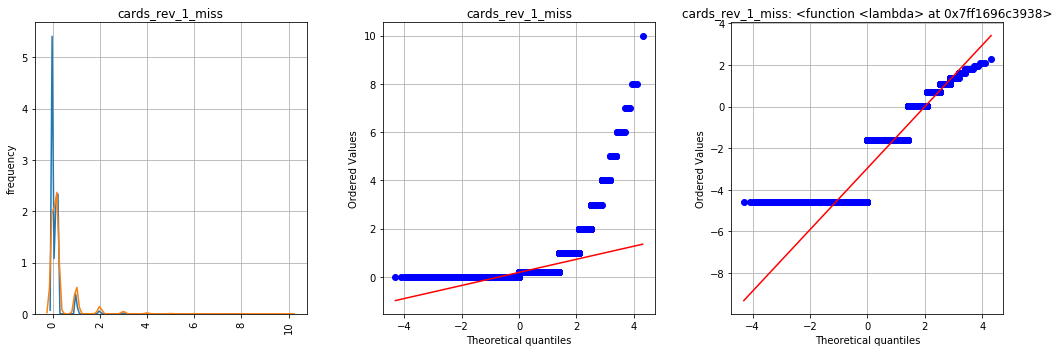

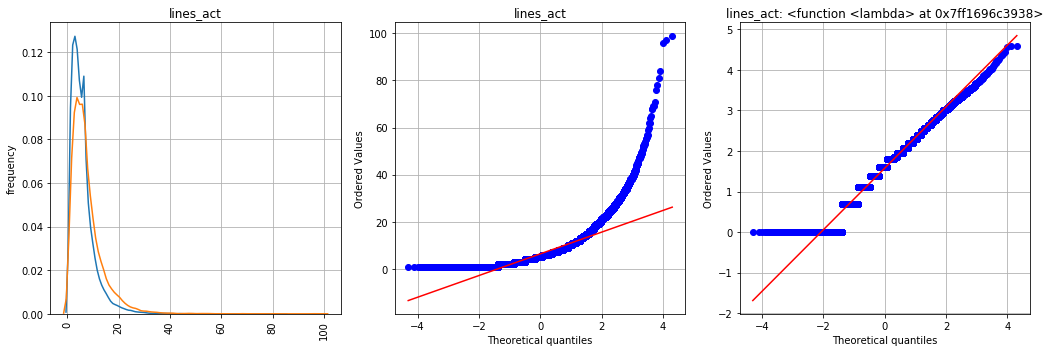

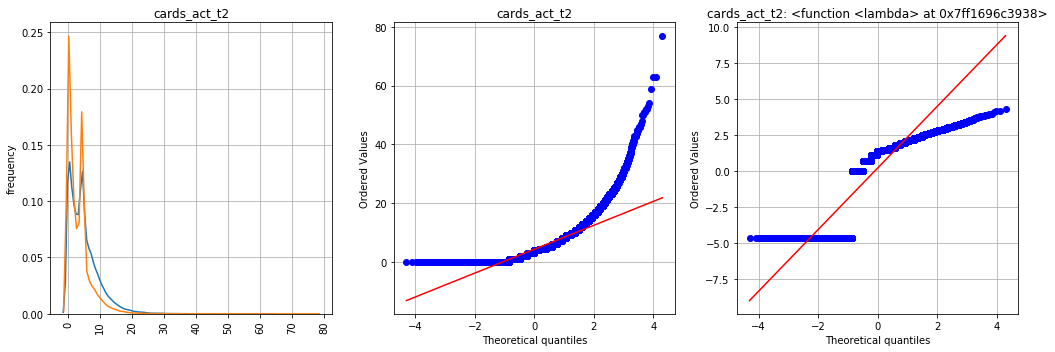

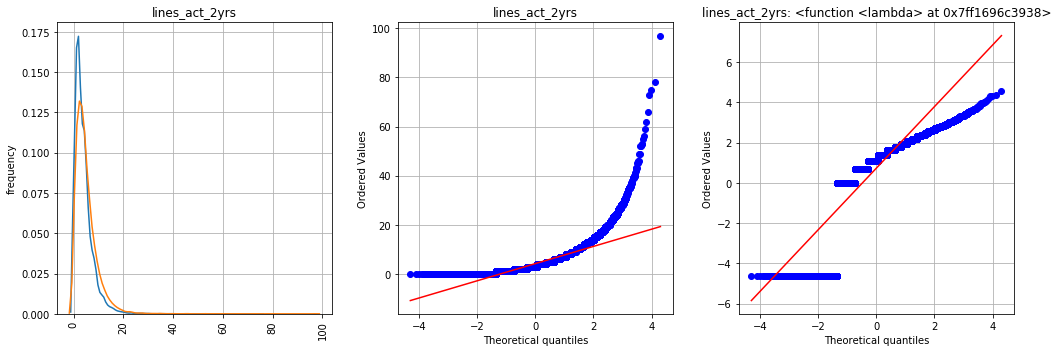

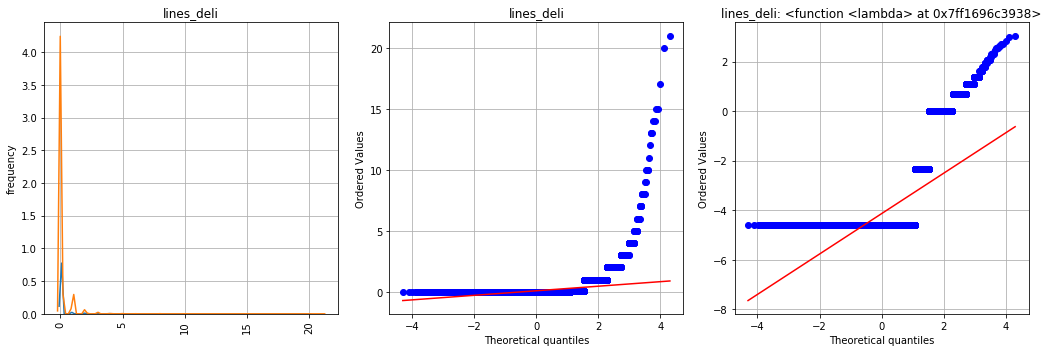

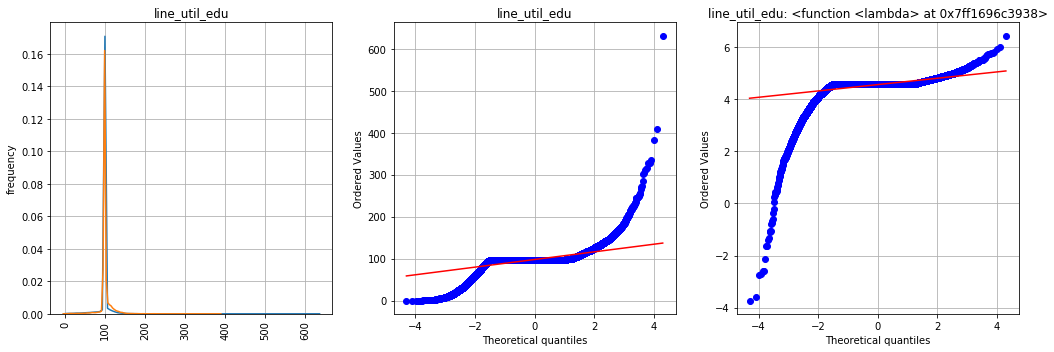

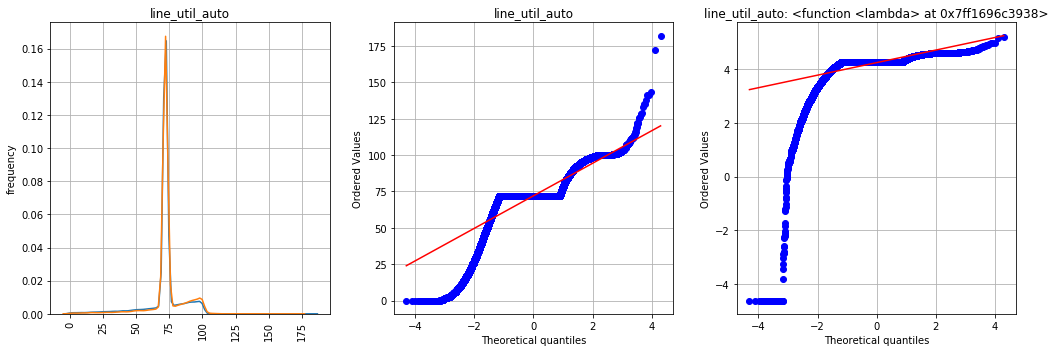

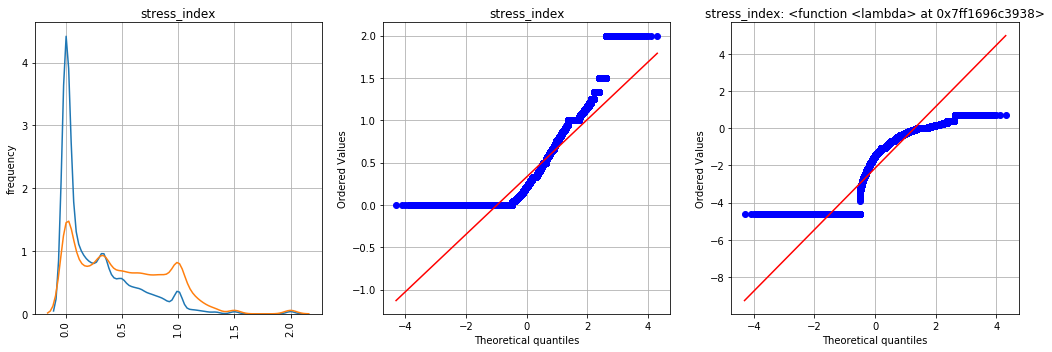

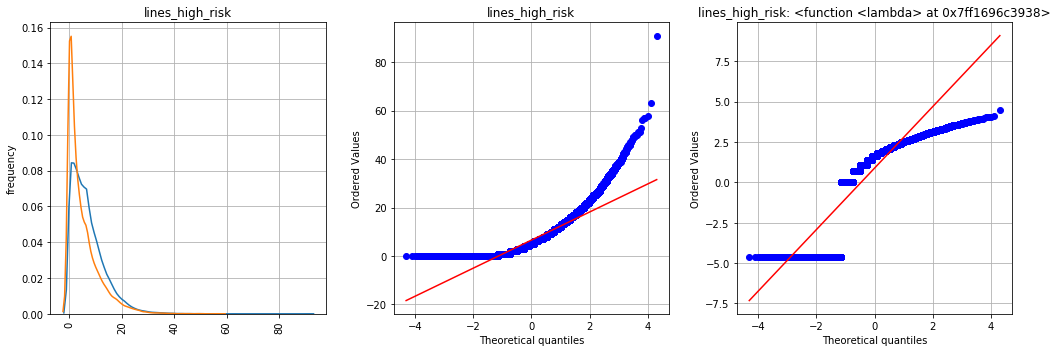

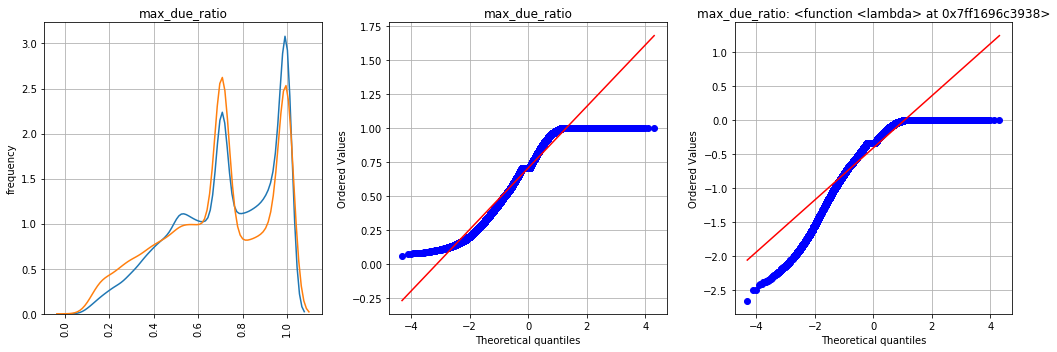

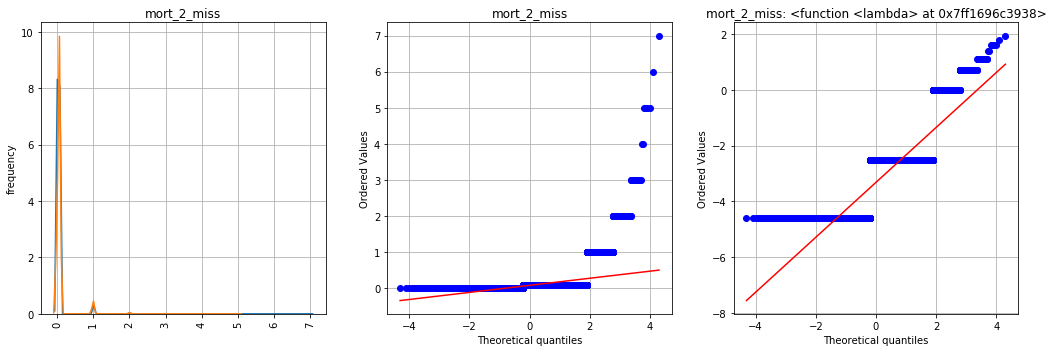

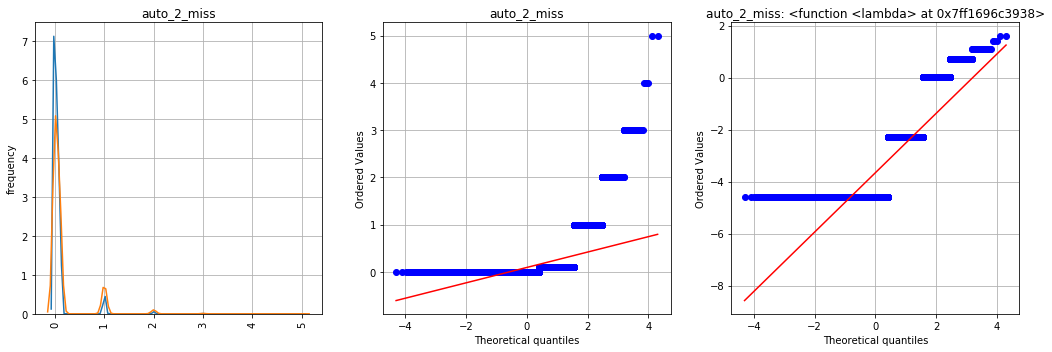

In [38]:
# Feature distributions for training data

num_cols = train.drop(['application_key', 'card_type', 
                              'location_id', 'default_ind'], axis=1).columns.tolist()
dist_dashboard(train, 'default_ind', num_cols, transform=lambda x: np.log(x + 0.01))

The key observation here is the fact the two classes are inseparable over most of the predictors (their KDE plots more or less coincide). This, in a way, will reduce our confidence in predicting whether a customer will default on payment or not.

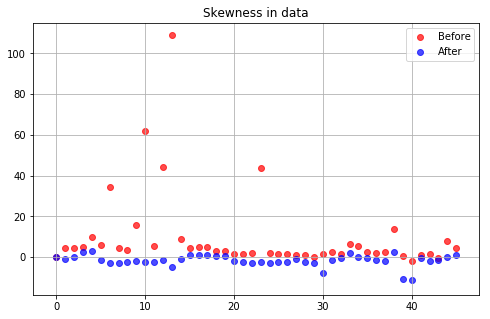

In [89]:
# Skewness of numeric columns before and after transformation
# Filling all missing values with mean temporarily

dummy_train = train
for col in train.columns:
    dummy_train[col] = dummy_train[col].fillna(dummy_train[col].mean())
    
col_names = dummy_train[num_cols].columns.values.reshape((1, -1))
prev_skew = dummy_train[num_cols].skew().values.reshape((1, -1))
post_skew = dummy_train[num_cols].apply(lambda x: np.log(x + 0.01)).skew().values.reshape((1, -1))
x_scatter = np.array([i for i in range(len(num_cols))]).reshape((1, -1))

# Plot skewness variation
plt.figure(figsize=(8, 5))
plt.scatter(x_scatter, prev_skew, color='red', marker='o', alpha=0.7)
plt.scatter(x_scatter, post_skew, color='blue', marker='o', alpha=0.7)
plt.grid()
plt.title('Skewness in data')
plt.legend(['Before', 'After'])
plt.show()

Except for two or three columns, log transformation helps reduce skewness significantly.

### Correlation Heatmap

In this section, we see how features interact with each other and to what extent. We do this by finding the correlation matrix of our data, and then rendering it on a heatmap using `seaborn`.

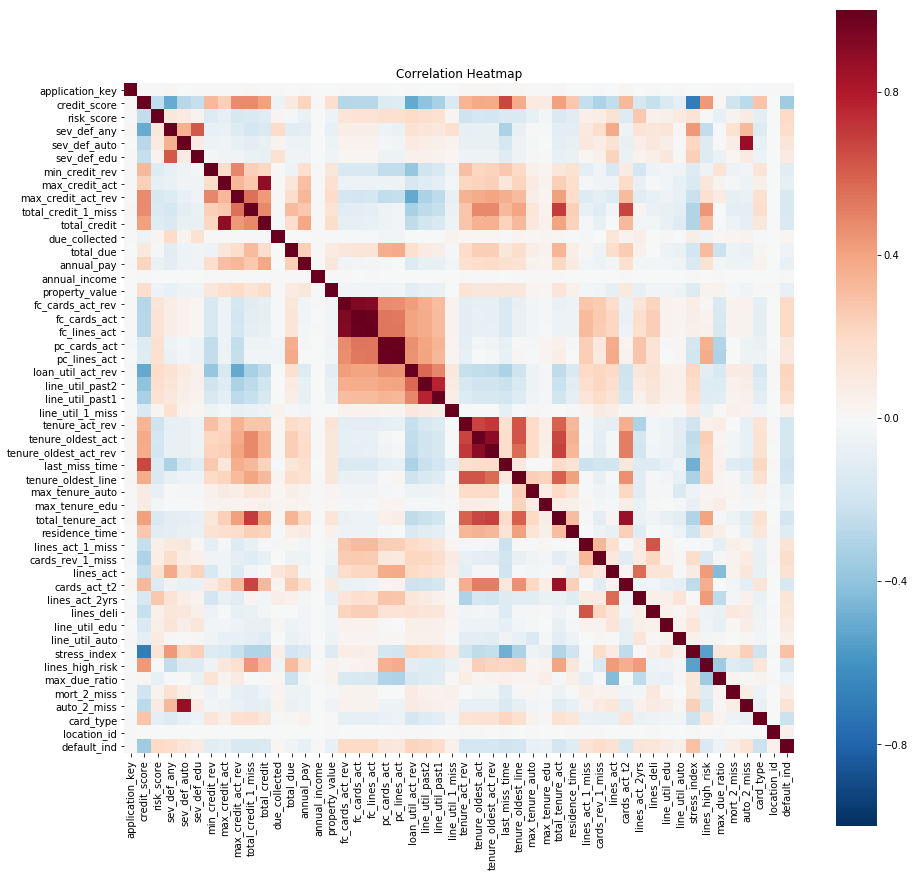

In [39]:
# Correlation heatmap

plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), square=True, annot=False, cmap='RdBu_r', vmin=-1.0, vmax=1.0)
plt.title('Correlation Heatmap')
plt.show()

**Some observations**

1. `credit_score` has large correlations with quite a few features. It might be useful to keep only `credit_score` as this alone will capture all the non-linear interactions between its contributors.
2. `default_ind` only has weak correlations with other features, confirming no data leakage
3. There are chunks of highly correlated features near the diagonal; that's perhaps because they're all semantically similar (only on different time scales)

### Principal Component Analysis (PCA)

In this section, we try to find the variables which carry most of the dataset's variance. Also, we will visualize the data in reduced dimensions to see if there is any obvious decision boundary.

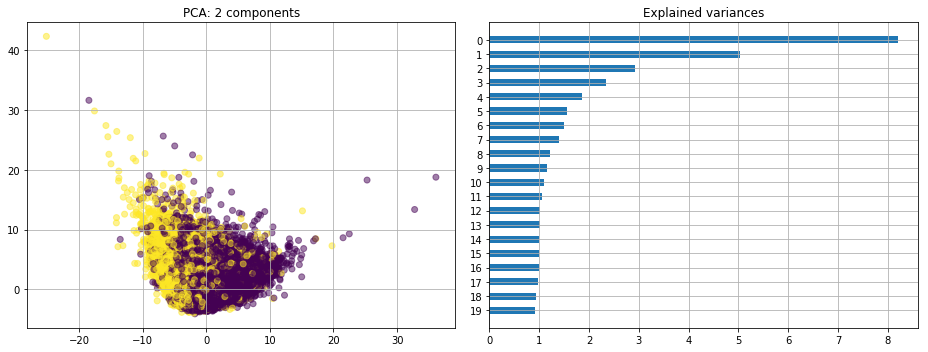

In [77]:
# Principal Component Analysis

target = train.default_ind.values
X = train.drop('default_ind', axis=1).values

# Scale values for better visualization
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_trans = pca.fit_transform(X_scaled)
x, y = X_trans[:, 0], X_trans[:, 1]

# Explained variances of top 20 principal components
pca_ev = PCA(n_components=20)
pca_ev.fit_transform(X_scaled)

components = np.array([19-i for i in range(20)])
variances = pca_ev.explained_variance_

# Plot both
plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.scatter(x, y, c=target, alpha=0.5)
plt.title('PCA: 2 components')
plt.grid()

plt.subplot(122)
plt.barh(components, width=variances, height=0.5)
plt.title("Explained variances")
plt.grid()
plt.yticks([i for i in range(20)], components)

plt.tight_layout()
plt.show()

It seems only about the first 4 or 5 components explain most of the variance. However, we will decide whether or not to remove them depending on whether our model overfits by keeping all predictors. Also, as expected, there is no discrenable decision boundary for the two default indicators.

### LightGBM Feature Importance

As you will see later, we will primarily used gradient boosted CART models to do our bidding. Their flexibility and accuracy makes them a popular choice for the problem at hand, especially considering how obscure the decision boundary is. In this section, we will train a LightGBM classifier on the data and extract the importance of every feature in classification. This will help us pick out important features.

Other feature selection methods including Recursive Feature Elimination (RFE) and Lasso Regularized Selector were also attempted. To see their implementation, check out our full EDA notebook [here](https://github.com/NishantPrabhu/MS4610-Project-2019/blob/master/code/EDA.ipynb).

In [90]:
# Function for doing the same

def lgbm_importance(df, uid=None, target=None, scale_pos_weight=1, ascending=True):
    
    cols = df.drop([uid, target], axis=1).columns.tolist()
    y = df[target].values
    X = df.drop([uid, target], axis=1).values
    
    model = LGBMClassifier(n_estimators=200,
                           learning_rate=0.05,
                           max_depth=4,
                           objective='binary',
                           scale_pos_weight=scale_pos_weight,
                           random_state=123)
    model.fit(X, y)
    f_imps = model.feature_importances_
    
    # Plot importances
    table = pd.DataFrame({'Column': cols, 'Importance': f_imps})
    table = table.sort_values(by='Importance', ascending=ascending)
    table = table.set_index(table['Column'])
    
    plt.figure(figsize=(10,10))
    table['Importance'].plot.barh()
    plt.title('Feature Importance')
    plt.grid()
    plt.show()

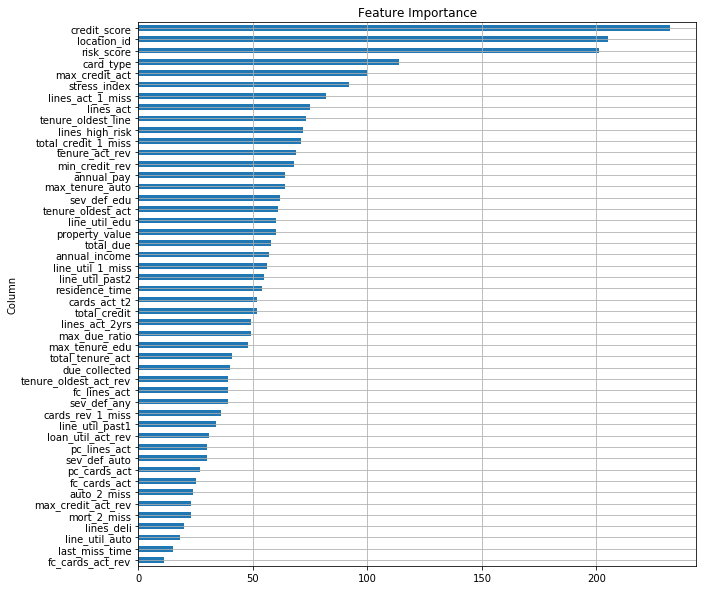

In [95]:
# Use it on the training data

lgbm_importance(train, uid='application_key', target='default_ind', scale_pos_weight=2.20, ascending=True)

It seems there are some columns which contribute significantly to classification, and most others which do not help much.

# Model Selection and Tuning

In this final section, we select a model that is stable and gives reasonable accuracies on the data. We have manually tuned hyperparameters by observing changes in performance metrics at each iteration (using cross-validation). Here, we present the results only for our best performing model: a Voting classifier with XGBoost and LightGBM estimators. The hyperparameters can be seen in the code below. Note that we decided to keep all features (except `application_key`) for prediction and left missing data as it was, because that gave us the best performance (in terms of accuracy and stability).

**PLEASE NOTE:**

To see all of our attempts (imputed data, more models, more feature selection related EDA, etc.) check out our notebooks in [this](https://github.com/NishantPrabhu/MS4610-Project-2019/tree/master/code) GitHub folder. In particular, [this](https://github.com/NishantPrabhu/MS4610-Project-2019/blob/master/code/ModelSelection.ipynb) is our complete Model Selection notebook. To keep this notebook clear and concise, we have skipped a great deal of our model selection process here.

In [96]:
# Evaluation metrics

from sklearn.metrics import roc_auc_score 
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [97]:
# Voting Classifier with XGBoost and LightGBM estimators

# Features and target are defined
y = train.default_ind
X = train.drop(['application_key', 'default_ind'], axis=1)
# cat_idx = np.where(X.dtypes != float)[0]

# Aggregate estimators
estimators = []

model_1 = XGBClassifier(n_estimators=300,
                      max_depth=9,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      subsample=0.5,
                      colsample_bytree=0.5,
                      scale_pos_weight=2.20,
                      random_state=123)
estimators.append(('xgb', model_1))

model_2 = LGBMClassifier(n_estimators=500,
                       max_depth=9,
                       learning_rate=0.05, 
                       objective='binary',
                       subsample=0.5,
                       colsample_bytree=0.5,
                       scale_pos_weight=2.20,
                       random_state=123)
estimators.append(('lgb', model_2))

# Voting Classifier
clf = VotingClassifier(estimators, voting='soft')
print('[INFO] Model Initialized')

# Scoring
scores = ['roc_auc', 'accuracy', 'balanced_accuracy', 'f1']
print('[INFO] Scoring started')
score_dict = cross_validate(clf, X, y, cv=5, scoring=scores)

train_scores = np.array([np.mean(score_dict['train_roc_auc']), np.mean(score_dict['train_accuracy']), 
                         np.mean(score_dict['train_balanced_accuracy']), np.mean(score_dict['train_f1'])])
test_scores = np.array([np.mean(score_dict['test_roc_auc']), np.mean(score_dict['test_accuracy']), 
               np.mean(score_dict['test_balanced_accuracy']), np.mean(score_dict['test_f1'])])
perf_table = pd.DataFrame(np.vstack((np.array(scores), train_scores, test_scores)).T, columns=['Metric', 'Train', 'Test'])
               
print(perf_table)

[INFO] Model Initialized
[INFO] Scoring started
              Metric               Train                Test
0            roc_auc  0.9257146447767646  0.7906293994954546
1           accuracy  0.8500602409638554  0.7491084337349398
2  balanced_accuracy  0.8384021545477609  0.7118027681508233
3                 f1  0.7566368036427398  0.5883137904504244
